In [3]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline


In [4]:
# Load dataset
data = pd.read_csv("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")

# Display the first few rows of the dataset
print("First five rows of the dataset:")
display(data.head())

# Display dataset information
print("\nDataset information:")
data.info()

# Check for class distribution
print("\nClass distribution:")
print(data['label'].value_counts())


First five rows of the dataset:


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB

Class distribution:
label
0    2500
1     500
Name: count, dtype: int64


In [5]:
# Data Preprocessing
# Drop missing values
data.dropna(inplace=True)

# Balance the dataset to avoid class imbalance issues
spam_count = data['label'].value_counts()
min_count = spam_count.min()

balanced_data = pd.concat([
    data[data['label'] == 0].sample(min_count, random_state=42),
    data[data['label'] == 1].sample(min_count, random_state=42)
])

# Display the balanced class distribution
print("Balanced class distribution:")
print(balanced_data['label'].value_counts())

# Display a sample of the balanced dataset
print("\nSample of the balanced dataset:")
display(balanced_data.head())


Balanced class distribution:
label
0    499
1    499
Name: count, dtype: int64

Sample of the balanced dataset:


,email,label
1447,on fri sep NUMBER NUMBER at NUMBER NUMBER NUMB...,0
1114,have you thought of bumping up sylpheed claws ...,0
1064,title page has a login screen and i can t seem...,0
2287,url URL date not supplied img URL wonderful ga...,0
1537,URL spamassassin contrib URL changed what rem...,0


In [6]:
# Tokenization: Convert text data into numerical vectors
vectorizer = CountVectorizer(max_features=12)
X = vectorizer.fit_transform(balanced_data['email']).toarray()

# Display sample tokenized data
print("Sample tokenized data:")
print(pd.DataFrame(X, columns=vectorizer.get_feature_names_out()).head())

# Add random embeddings of size 10 for each word
embedding_size = 10
embedded_X = np.zeros((X.shape[0], 12, embedding_size))
for i, sample in enumerate(X):
    embedded_X[i] = np.random.rand(12, embedding_size) * sample[:, None]

# Flatten embeddings for input into the neural network
X_flattened = embedded_X.reshape(embedded_X.shape[0], -1)
y = balanced_data['label'].values


Sample tokenized data:
   and  for  in  is  number  of  that  the  this  to  url  you
0    1    0   1   1       7   0     1    3     0   3    1    2
1    0    0   0   0       0   1     0    0     0   0    3    1
2    1    1   0   2       0   0     0    1     0   1    1    0
3    2    0   0   0       4   2     0    1     0   1    5    0
4    2    2   0   2       5   0     0    8     3   3   10    3


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y, test_size=0.2, random_state=42)

# Display the shapes of the splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (798, 120)
Testing set shape: (200, 120)


In [8]:
# Define a two-layer neural network class
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.rand(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.rand(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return z * (1 - z)
    
    def forward(self, X):
        # Forward propagation
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    def backward(self, X, y, output):
        # Backward propagation
        m = X.shape[0]
        self.dZ2 = output - y
        self.dW2 = np.dot(self.A1.T, self.dZ2) / m
        self.db2 = np.sum(self.dZ2, axis=0, keepdims=True) / m
        self.dZ1 = np.dot(self.dZ2, self.W2.T) * self.sigmoid_derivative(self.A1)
        self.dW1 = np.dot(X.T, self.dZ1) / m
        self.db1 = np.sum(self.dZ1, axis=0, keepdims=True) / m
    
    def update_weights(self, learning_rate):
        # Update weights
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2
    
    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            self.update_weights(learning_rate)
            if (epoch + 1) % 100 == 0:
                loss = np.mean((y - output) ** 2)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    
    def predict(self, X):
        output = self.forward(X)
        return np.where(output > 0.5, 1, 0)


In [10]:
# Initialize and train the model
input_size = X_train.shape[1]
hidden_size = 8
output_size = 1

model = TwoLayerNN(input_size, hidden_size, output_size)

# Reshape y_train for compatibility with the model
y_train_reshaped = y_train.reshape(-1, 1)

# Train the model
model.train(X_train, y_train_reshaped, epochs=200000, learning_rate=0.01)


Epoch 100/200000, Loss: 0.2498
Epoch 200/200000, Loss: 0.2497
Epoch 300/200000, Loss: 0.2496
Epoch 400/200000, Loss: 0.2494
Epoch 500/200000, Loss: 0.2492
Epoch 600/200000, Loss: 0.2489
Epoch 700/200000, Loss: 0.2484
Epoch 800/200000, Loss: 0.2473
Epoch 900/200000, Loss: 0.2455
Epoch 1000/200000, Loss: 0.2429
Epoch 1100/200000, Loss: 0.2390
Epoch 1200/200000, Loss: 0.2341
Epoch 1300/200000, Loss: 0.2280
Epoch 1400/200000, Loss: 0.2209
Epoch 1500/200000, Loss: 0.2131
Epoch 1600/200000, Loss: 0.2049
Epoch 1700/200000, Loss: 0.1965
Epoch 1800/200000, Loss: 0.1876
Epoch 1900/200000, Loss: 0.1788
Epoch 2000/200000, Loss: 0.1710
Epoch 2100/200000, Loss: 0.1641
Epoch 2200/200000, Loss: 0.1580
Epoch 2300/200000, Loss: 0.1527
Epoch 2400/200000, Loss: 0.1482
Epoch 2500/200000, Loss: 0.1442
Epoch 2600/200000, Loss: 0.1408
Epoch 2700/200000, Loss: 0.1377
Epoch 2800/200000, Loss: 0.1351
Epoch 2900/200000, Loss: 0.1328
Epoch 3000/200000, Loss: 0.1306
Epoch 3100/200000, Loss: 0.1287
Epoch 3200/200000

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Evaluation Metrics:
Accuracy: 0.8050
Precision: 0.8384
Recall: 0.7830
F1 Score: 0.8098


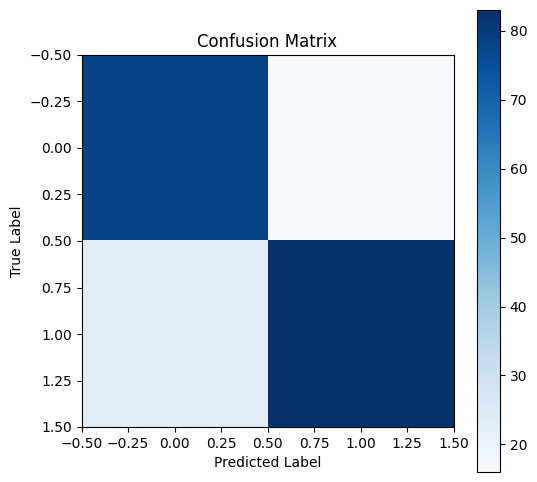

In [12]:
# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()
